In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd
import pickle

In [4]:
path =  '/content/drive/MyDrive/DEAP DS/'
files = os.listdir(path)

In [9]:
dat_files = [file1 for file1 in files if file1.endswith('.dat')]

In [10]:
data = []
labels = []

for file1 in dat_files:
  file_path = os.path.join(path,file1)
  with open(file_path,'rb') as file2:
    file_data = pickle.load(file2, encoding='latin1')
    data.append(file_data['data'])
    labels.append(file_data['labels'])

In [11]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(32, 40, 4)
(32, 40, 40, 8064)


In [12]:
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)

(1280, 4)
(1280, 40, 8064)


In [13]:
eeg_data = data[:,:32,:]
print(eeg_data.shape)

(1280, 32, 8064)


----------------------------------------------------------------------------

***Kurtosis*** indicates how much data resides in the tails.

***Skewness*** is the degree of asymmetry observed in a probability distribution.Distributions can be positive and right-skewed, or negative and left-skewed.


In [15]:
#this code is to extract the main features.
# Function to calculate statistical features for each EEG band
def calculate_statistical_features(data):
    # Compute mean, standard deviation, kurtosis, and skewness
    mean = np.mean(data, axis=1)
    std_dev = np.std(data, axis=1)
    kurt = kurtosis(data, axis=1)
    skewness = skew(data, axis=1)
    # Combine features into a single array
    features = np.vstack((mean, std_dev, kurt, skewness)).T
    return features

In [16]:
# Calculate statistical features for each EEG band separately
eeg_stat_features = []
for band_data in eeg_data.transpose(1, 0, 2):
    band_features = calculate_statistical_features(band_data)
    eeg_stat_features.append(band_features)

In [17]:

# Concatenate features horizontally
eeg_stat_features = np.concatenate(eeg_stat_features, axis=1)


In [18]:
# Print the shape of the calculated features
print("Shape of statistical features:", eeg_stat_features.shape)


Shape of statistical features: (1280, 128)


In [19]:
# Convert features to a DataFrame for better visualization
df_stat_features = pd.DataFrame(eeg_stat_features)

# Display the DataFrame
print(df_stat_features)

           0         1          2         3         4          5          6    \
0    -0.028259  3.889422   0.743994 -0.046640 -0.015335   4.214492   1.329109   
1    -0.082712  4.260994   0.710815 -0.083895 -0.031351   4.599634   0.851373   
2     0.060689  4.317223   0.822480 -0.032862  0.081124   4.728715   1.665044   
3    -0.027773  3.961901   0.869061 -0.061074 -0.011902   4.352078   1.322036   
4    -0.062537  3.522773   0.368222  0.012391 -0.072949   3.675880   0.835610   
...        ...       ...        ...       ...       ...        ...        ...   
1275 -0.015068  4.255723   0.785196 -0.187781 -0.439097  20.216307   7.920831   
1276 -0.074093  4.624853   0.950409 -0.174292 -0.608723  21.732170  12.642059   
1277 -0.012218  4.211918   0.797275 -0.109377  0.272855  20.021320   9.018652   
1278  0.048134  5.774315  11.005193 -0.974325  0.047834  16.377353   8.394971   
1279 -0.030110  4.303603   0.671005 -0.224528  0.049626  19.049399  13.205100   

           7         8     

In [20]:
from scipy.signal import welch
from scipy.integrate import simps
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp


In [21]:

def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "delta"):
        bd = (0.5,4)
    if (band == "theta"):
        bd = (4,8)
    elif (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(eeg_data[people,channel], 128, bd)

In [22]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"delta"))
        eeg_band.append(get_band_power(i,j,"theta"))
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))



In [23]:
eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,160)) # 5×32
print(eeg_band.shape)


(1280, 160)


In [24]:
df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})
df_label

,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
...,...,...,...,...
1275,3.91,6.96,5.82,3.12
1276,2.81,6.13,6.06,1.04
1277,3.05,7.01,5.10,1.10
1278,3.99,7.17,4.85,1.00


In [25]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Valence    1280 non-null   float64
 1   Arousal    1280 non-null   float64
 2   Dominance  1280 non-null   float64
 3   Liking     1280 non-null   float64
dtypes: float64(4)
memory usage: 40.1 KB


In [26]:
df_label.describe()

,Valence,Arousal,Dominance,Liking
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [27]:
label_name = ["valence","arousal","dominance","liking"]
labels_valence = []
labels_arousal = []
labels_dominance = []
labels_liking = []
for la in labels:
    l = []
    if la[0]>5:
        labels_valence.append(1)
    else:
        labels_valence.append(0)
    if la[1]>5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)
    if la[2]>5:
        labels_dominance.append(1)
    else:
        labels_dominance.append(0)
    if la[3]>6:
        labels_liking.append(1)
    else:
        labels_liking.append(0)

In [28]:
data_x = eeg_stat_features
print(data_x.shape)

# label_y = labels_valence
label_y = labels_arousal

# label_y = labels_dominance
# label_y = labels_liking
trainscores = []
testscores = []

(1280, 128)


------------------------------------
***KNN***

In [29]:
X = data_x
from sklearn import preprocessing

poly = preprocessing.PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X)
# X=preprocessing.scale(X)
X = preprocessing.normalize(X, norm='l1')
print(X.shape)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=1000)
# X=pca.fit_transform(X)
# print(X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_y)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train,)
train_score=knn.score(X_train,y_train)
test_score=knn.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

(1280, 8385)
train_score： 0.7020833333333333
test_score： 0.584375


------------------------------
***SMV***

In [30]:

poly = preprocessing.PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

# min_max_scaler = preprocessing.MinMaxScaler()
# X=min_max_scaler.fit_transform(X)
X=preprocessing.scale(X)
# X = preprocessing.normalize(X, norm='l2')
print(X.shape)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# X=pca.fit_transform(X)
# print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)

(1280, 8385)


In [31]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',C = 0.1)
svc.fit(X_train, y_train)
train_score=svc.score(X_train,y_train)
test_score=svc.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)


train_score： 0.584375
test_score： 0.55


---------------------------------------
***Decision Tree***

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X)
# X=preprocessing.scale(X)
# X = preprocessing.normalize(X, norm='l1')
print(X.shape)

# Dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X=pca.fit_transform(X)
print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=20,min_samples_split=4)
dtree = dtree.fit(X_train, y_train)
train_score=dtree.score(X_train,y_train)
test_score=dtree.score(X_test,y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)


(1280, 8385)
(1280, 100)
train_score： 0.9875
test_score： 0.575


--------------------------------
***Random Forest***

In [33]:
min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X)
# X=preprocessing.scale(X)
# X = preprocessing.normalize(X, norm='l1')
print(X.shape)

# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# X=pca.fit_transform(X)
# print(X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_x, label_y)


from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)
rf=rf.fit(X_train, y_train)
train_score=rf.score(X_train,y_train)
test_score=rf.score(X_test,

y_test)
print("train_score：", train_score)
print("test_score：", test_score)
trainscores.append(train_score)
testscores.append(test_score)



(1280, 100)
train_score： 0.9979166666666667
test_score： 0.621875


---------------------------
***Model comparison***

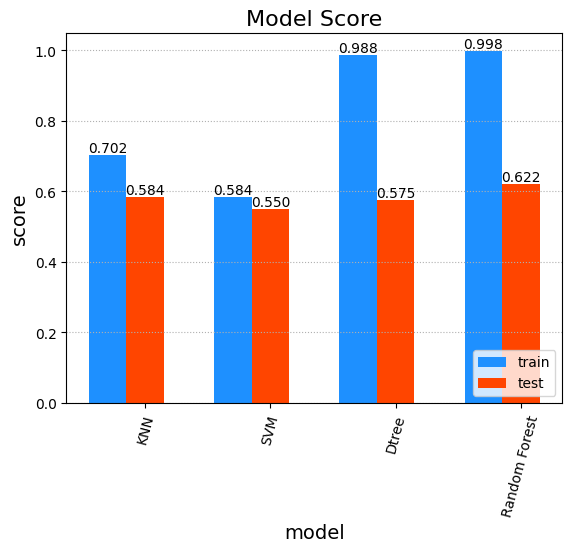

In [34]:
model_name = ["KNN","SVM","Dtree","Random Forest"]
import matplotlib.pyplot as plt
plt.title('Model Score', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('score', fontsize=14)
plt.grid(linestyle=':', axis='y')
x = np.arange(4)
a = plt.bar(x - 0.3, trainscores, 0.3, color='dodgerblue', label='train', align='center')
b = plt.bar(x, testscores, 0.3, color='orangered', label='test', align='center')
# Set up labels
for i in a + b:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % h, ha='center', va='bottom')
plt.xticks(x,model_name,rotation=75)
plt.legend(loc='lower right')
plt.show()